In [91]:
import os 
import sys

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import re

import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")

from models.equivariant_mpnn import MPNNPORE

from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
data = get_zeolite('MOR')

ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
_, _, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l)

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)


In [3]:
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)


In [48]:
def get_ats(idx):
    with open(f'Data_isotherms/isomors/MOR_{idx}.cif') as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = [1 if i[0]=='Al' else 0 for i in at_pos]
    return atom

def get_iso(idx):
    with open(f'Data_isotherms/curves/plot_data_{idx}') as f:
        lines = f.read()
        p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?)', lines)

    p = [float(i) for i in p]
    return p

def langmuirfreudlich(p, x):
    return p[:,0]*p[:,1]*x**p[:,2]/(1.0+p[:,1]*x**p[:,2])+p[:,3]*p[:,4]*x**p[:,5]/(1.0+p[:,4]*x**p[:,5])
    

In [45]:
n = 989

atoms = np.zeros((n, 48))
iso_params = np.zeros((n, 6))


for zeo in tqdm(range(n)):

    atoms[zeo] = get_ats(zeo)
    iso_params[zeo] = get_iso(zeo)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:00<00:00, 2981.93it/s]


In [88]:
langmuirfreudlich(iso_params[[0]], np.arange(100))

array([0.        , 2.11965359, 2.32771609, 2.41968125, 2.47328086,
       2.5089744 , 2.53471545, 2.55429546, 2.56976999, 2.58235778,
       2.59283084, 2.60170373, 2.60933369, 2.61597702, 2.62182278,
       2.62701371, 2.63165972, 2.63584695, 2.63964393, 2.64310588,
       2.64627789, 2.64919712, 2.65189449, 2.65439598, 2.65672359,
       2.65889605, 2.66092944, 2.66283764, 2.66463271, 2.66632516,
       2.66792422, 2.66943802, 2.67087374, 2.67223776, 2.67353577,
       2.67477286, 2.67595359, 2.67708208, 2.67816202, 2.67919679,
       2.68018943, 2.68114271, 2.68205915, 2.68294108, 2.6837906 ,
       2.68460967, 2.68540005, 2.68616341, 2.68690126, 2.687615  ,
       2.68830594, 2.68897528, 2.68962414, 2.69025356, 2.69086451,
       2.6914579 , 2.69203458, 2.69259533, 2.69314089, 2.69367197,
       2.6941892 , 2.6946932 , 2.69518454, 2.69566377, 2.6961314 ,
       2.6965879 , 2.69703374, 2.69746933, 2.69789508, 2.69831139,
       2.6987186 , 2.69911707, 2.69950712, 2.69988906, 2.70026

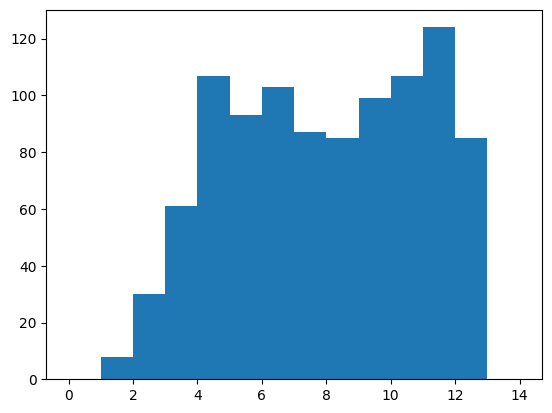

In [11]:
plt.hist(atoms.sum(1), bins=np.arange(0, 15));

In [78]:
def get_pred_points(steps):

    return 10**np.arange(1,8,1/steps)
    

In [90]:
class calculate_distance(nn.Module):

    def __init__(self, n_points=100):
        super().__init__()

        self.points = 10**np.arange(1,8,7/n_points)
        self.n_points = n_points
        
    def forward(self, param_p_hat, param_p):
        # add channels dimension
        param_p_hat = param_p_hat[:,None]

        p_hat = F.interpolate(param_p_hat, self.n_points, align_corners=True, mode='linear').squeeze()
        p = langmuirfreudlich(p, self.points)

        loss = ((p_hat - p)**2).sum(1)
        
        return loss
        

        
    

In [79]:
pred_points = get_pred_points(5)

In [95]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                centers=10, mx_d=6, width=1, pool='sum', 
                out_size=len(pred_points)).to('cuda')

In [63]:
np.log(10000000)/np.log(10)

7.0

In [60]:
1 * 10**2.25

177.82794100389228

In [82]:
a = 10**np.arange(1,8, 7/100)

In [83]:
a.shape

(100,)